In [2]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

figsize = (14, 3.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Assessing Feature Importance

## Importance of an Attribute

**Let's think again about the structure of DT models**

<center>
<img src="assets/DT.png" width=50%/>
</center>

* Every node is associated to an attribute
* ...And leads to an impurity reduction at training time

**Intuitively, the attribute is _responsible for the reduction_**

## Importance of an Attribute

**By summing the reductions on a whole tree**

...We can compute _attribute importance_ scores

* These typically normalized so as to sum up to 1
* Hence, if an attribute $j$ has importance 0.3
* ...Then 30% of the impurity reduction was due to that attribute

In scikit-learn, this computation is done by default at training time

**To see that in action, let's start by loading the housing dataset**

In [3]:
data = pd.read_csv('data/real_estate.csv', sep=',')
in_cols = np.array([c for c in data.columns if c != 'price per area'])
X = data[in_cols]
y = np.log(data['price per area'])
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.34, random_state=42)

## Attribute Importance in scikit-learn

**After training, the importances are available in a class attribute**

In [7]:
dt = DecisionTreeRegressor()
dt.fit(X_tr, y_tr);
print(dt.feature_importances_)

[0.11869175 0.61372984 0.02636489 0.07882621 0.16238732]


* Due to how the scores are computed, there is no need for standardization
  - Range differences are not a problem with DTs
* Since DTs are non-linear, the score can account for non-linear relations
* ...But for the same reason they lack sign information
  - We do not get to know the "direction" of the impact of an attribute

## Attribute Importance in scikit-learn

**Let's plot the importances**

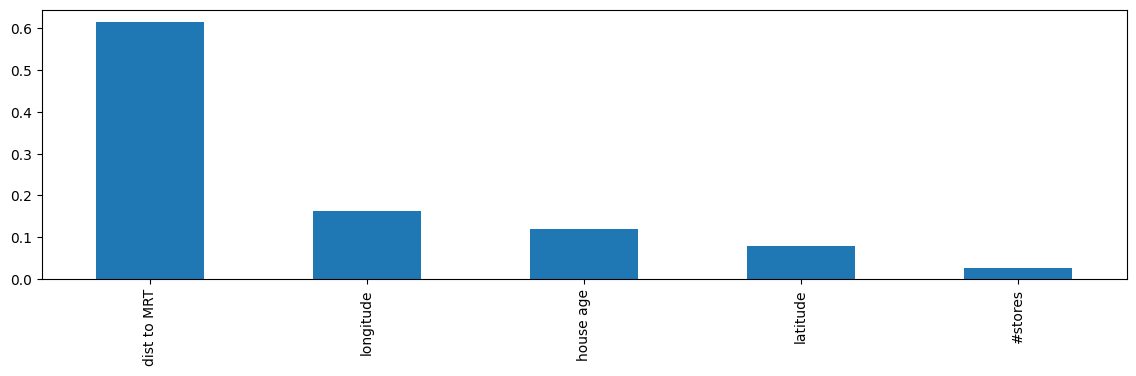

In [11]:
sorted_idx = np.argsort(-dt.feature_importances_)
dt_is = pd.Series(data=dt.feature_importances_[sorted_idx], index=in_cols[sorted_idx])
dt_is.plot.bar(figsize=figsize);

* Our tree is (finally) making some use of the longitude attribute!

## Attribute Importance in Random Forest

**A similar approach can be applied to Random Forests**

...Except that with RF we get one importance vector _per tree_

* From this we can obtain means (automatically computed by scikit-learn)
* ...But also _standard deviations_

In [13]:
rf = RandomForestRegressor()
rf.fit(X_tr, y_tr)

rf_is_mean = rf.feature_importances_
rf_is_std = np.std([t.feature_importances_ for t in rf.estimators_], axis=0)
print(f'Importance means: {rf_is_mean}')
print(f'Importance stdev: {rf_is_std}')

Importance means: [0.11359991 0.64357745 0.01839265 0.11583321 0.10859678]
Importance stdev: [0.03514064 0.05354356 0.01088743 0.05262241 0.05594543]


This information can be used for statistical consideration

* E.g. for discarding features based on a p-value

## Attribute Importance in Random Forest

**Let's plot the RF importances**

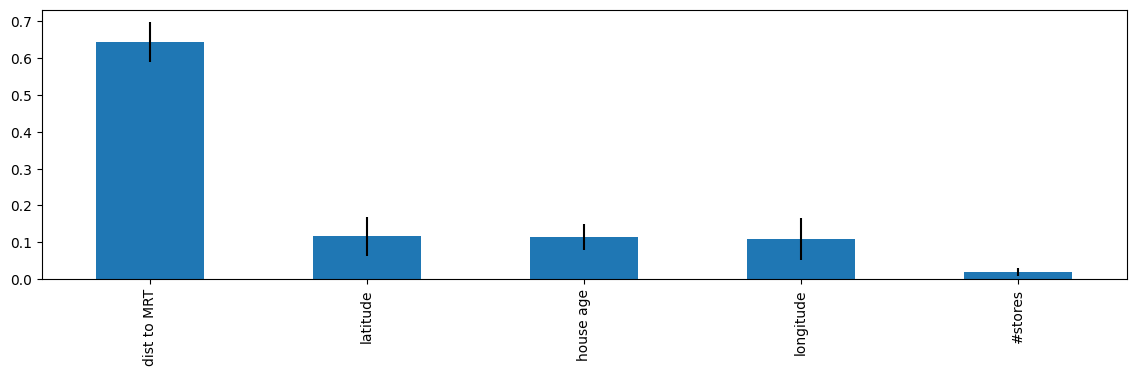

In [17]:
sorted_idx = np.argsort(-rf_is_mean)
rt_is = pd.Series(data=rf_is_mean[sorted_idx], index=in_cols[sorted_idx])
rt_is.plot.bar(figsize=figsize, yerr=rf_is_std[sorted_idx]);

* Both "house age" and "longitude" have an unsually large error bar
* "#stores" should arguably be discarded

## Limitations of Impurity Importances

**These scores are sometimes called _impurity based importance_**

They have several advantages:

* They are very cheap to compute
* They account for non-linear effects
* They come with statistical information (for RFs)

However, they also have some limitations

* They are only as reliable as the model that is making the predictions
  - Never trust importances for an inaccurate model!
* They may give an unfair advantage to attributes with many values
  - If an attribute has many distinct values
  - ...Accidental correlation with the target becomes more likely

## Permutation Importance

**Let's consider again our current issue**

* Attributes with certain distributions (e.g. many values, roughly uniformly spread)
* ...Tend to be favored by impurity-based importance

**How can we address this?**

For example we could compare the performance of two variants of a model:

* One trained on the original data
* ...And one trained on a modified dataset, where:
  - The _correlation_ between an attribute $j$ and the target has been _destroyed_
  - ...But the _distribution_ of attribute $j$ is _intact_

**The gap in model accuracy will be a measure of the importance of $j$**

## Permutation Importance

**We can achieve this by _permuting the values of an attribute $j$_**

By doing so:

* Any correlation between $j$ and the target becomes statistically unlikely
* ...But the distribution of $j$ stays exacly the same

**Then we can proceed as planned**

* We train variants of the model
* We compute the values of a chosen quality metric (e.g. MSE, accuracy)
* We repeat for all attributes
* ...And finally we can normalize like for the impurity-based importances

**This type of score is known as _permutation importance_**

## Permutation Importance

**The approach is pre-implemented in scikit-learn**

In [27]:
from sklearn.inspection import permutation_importance
res = permutation_importance(rf, X_tr, y_tr, n_repeats=30, random_state=42)

The function allows us to specify a number of repetitions

* Repeating is a good idea since we are relying on random permutations
* ...And allows us to obtain standard deviations

**Both results can be accessed from the returned "result" object:**

In [29]:
p_rf_is_mean, p_rf_is_std = res.importances_mean, res.importances_std
print(f'Importance means: {p_rf_is_mean}')
print(f'Importance stdevs: {p_rf_is_std}')

Importance means: [0.18171128 1.02282367 0.02192556 0.17061133 0.15844575]
Importance stdevs: [0.01831143 0.07369997 0.00333805 0.01474629 0.01185921]


## Permutation Importance

**We can plot the results as usual**

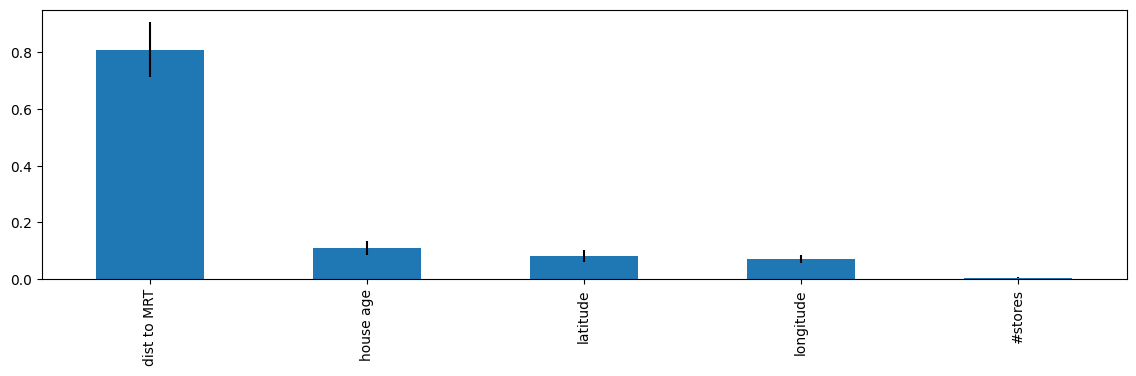

In [26]:
sorted_idx = np.argsort(-p_rf_is_mean)
dt_is = pd.Series(data=p_rf_is_mean[sorted_idx], index=in_cols[sorted_idx])
dt_is.plot.bar(figsize=figsize, yerr=p_rf_is_std[sorted_idx]);

The new results are consistsent with the previous ones (and more reliable)

## Some Final Consideration

**Permutation importances have some strong advantave over impurity ones**

* They can be computed for a wide range of estimators (not just tree)
* They are not biased towards certain attributes
* They naturally lend themselves to statistical analysis

**As a main drawback, they are more expensive to compute**

* They require to evaluate multiple models
* ...And to repeat the process multiple times